In [181]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pandas as pd

import pathlib
import math
from itertools import islice 
import sys
sys.path.append('/workspace/product_classifier/')

In [182]:
from bidi.algorithm import get_display
import arabic_reshaper

def farsiz(string):
    reshaped_text = arabic_reshaper.reshape(u'{}'.format(string))
    return get_display(reshaped_text)

# PATH TO DATA.. 

In [183]:
!ls /workspace/product_classifier/data/milk

misc  note.txt	test  test-0  test_shelf_crop  train-val  xy.h5


# LIST SAVED MODELS

In [184]:
!ls /workspace/product_classifier/saved_models/milk/

resnet50  tensorboard_logs


In [185]:
base_model_name = 'resnet50'

In [186]:
!ls /workspace/product_classifier/saved_models/milk/$base_model_name

checkpoints  RESNET50_Freeze_80_0001_n_21_epoch


In [187]:
trained_model_name = 'RESNET50_Freeze_80_0001_n_21_epoch'

In [188]:
csv = pd.read_csv(f'/workspace/product_classifier/saved_models/milk/resnet50/{trained_model_name}/vms_code_mapping.csv')

In [189]:
# f'/workspace/product_classifier/saved_models/milk/{base_model_name}/{trained_model_name}'

In [190]:
# !rm -r '/workspace/product_classifier/s!rm -r '/workspace/product_classifier/saved_models/milk/resnet50/35_epoch_001_lr_finetune80/'aved_models/milk/resnet50/35_epoch_001_lr_finetune80/'

# LOAD MODEL

In [191]:
model = \
    load_model(
    f'/workspace/product_classifier/saved_models/milk/{base_model_name}/{trained_model_name}',
    custom_objects={"F1Score": tfa.metrics.F1Score}
#     compile=False
)
model.summary()

probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 69)                141381

# DATA GENERATOR 

In [192]:
train_val_dir = '/workspace/product_classifier/data/milk/train-val/'
# test_dir = '/workspace/product_classifier/data/milk/test/'
test_dir = '/workspace/product_classifier/data/milk/test_shelf_crop/'

from utils.data_loader import load_data_flow_from_directory
data_flow = \
load_data_flow_from_directory(
    train_val_dir,
    test_dir,
    (224,224),
    1)

Found 8429 images belonging to 139 classes.
Found 2041 images belonging to 139 classes.
Found 52 images belonging to 139 classes.


In [193]:
import os
trainfiles = set(os.listdir(train_val_dir))
testfiles = set(os.listdir(test_dir))
testfiles - trainfiles

{'325577'}

# INFO

In [194]:
all_products = pd.read_csv('/workspace/all_products.csv')
all_products = all_products.dropna(subset=['vms_food_id'])

all_products= all_products.astype({'vms_food_id' : int})

dict_milk_vms_title = all_products[all_products.CAT == 'MILK'][['vms_food_id','title']].set_index('vms_food_id').to_dict()

In [214]:
num_samples = 52

In [215]:
# from itertools import islice
test_images_labels = list(islice(data_flow['test'], num_samples))
test_images , labels = list(zip(*test_images_labels))
num_classes = data_flow['test'].num_classes
test_labels = data_flow['test'].labels

calss_mapping_dict = data_flow['test'].class_indices
calss_mapping_dict = {y:x for x,y in calss_mapping_dict.items()}

# EVALUATE ON TEST DATE

In [216]:
model.evaluate(data_flow['test'])

52/52 [==============================] - 1s 12ms/step - loss: 1.5585 - accuracy: 0.5962 - precision: 0.6739 - recall: 0.5962 - f1_score: 0.0423


[1.5584882497787476,
 0.5961538553237915,
 0.6739130616188049,
 0.5961538553237915,
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5714286 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.44444448,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.6666667 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

In [217]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [218]:
Y_true = data_flow['test'].labels
preds = model.predict(data_flow['test'])
preds = np.argmax(preds,axis=1)

preds = np.where(~np.isin(preds , Y_true, ),
        -1,
        preds)

Y_true = np.where(~np.isin(Y_true, preds, ),
        -1,
        Y_true)

set_Y_true =list(set(Y_true))
set_Y_true

vms_true = [calss_mapping_dict.get(x) for x in set_Y_true]

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'label 33 : vms 222961 ﯼﺮﺘﯿﻟ ۱ ﮎﺎﭘ ﺏﺮﭼ ﻢﯿﻧ ﺮﯿﺷ'),
  Text(1.5, 0, 'label 39 : vms 234284 ﯼﺮﺘﯿﻟ ۲ ﻥﺍﺰﯿﻧﺎﻣ %۱.۵ ﺏﺮﭼ ﻢﮐ ﺮﯿﺷ'),
  Text(2.5, 0, 'label 7 : vms 12548 ﯼﺮﺘﯿﻟ ﯽﻠﯿﻣ ۹۵۰ ﻥﺍﺭﺍﺪﻣﺍﺩ ﺏﺮﭼ ﻢﮐ ﻩﺰﯾﺭﻮﺘﺳﺎﭘ ﺮﯿﺷ'),
  Text(3.5, 0, 'label 74 : vms 301104 ﯼﺮﺘﯿﻟ ﯽﻠﯿﻣ ۹۵۰ ﻦﻬﯿﻣ ﺏﺮﭼﺮﭘ %۳.۲ ﺮﯿﺷ'),
  Text(4.5, 0, 'label 14 : vms 171721 ﯼﺮﺘﯿﻟ ﯽﻠﯿﻣ ۹۵۰ ﻥﺍﺰﯿﻧﺎﻣ ﯽﺑﺮﭼ ٪۳ ﺏﺮﭼﺮﭘ ﺮﯿﺷ'),
  Text(5.5, 0, 'label 79 : vms 312280 ﯼﺮﺘﯿﻟ 1 ﺲﯿﻟﺎﻋ ﺏﺮﭼ ﻢﮐ ﺎﻣﺩﺍﺮﻓ ﺮﯿﺷ'),
  Text(6.5, 0, 'label 88 : vms 314760 ﯼﺮﺘﯿﻟ ﯽﻠﯿﻣ ۸۰۰ ﮎﺎﭘ ﺏﺮﭼ ﻢﮐ D ﻦﯿﻣﺎﺘﯾﻭ ﺮﯿﺷ'),
  Text(7.5, 0, 'label 59 : vms 270061 ﯼﺮﺘﯿﻟ ﯽﻠﯿﻣ 946 ﮏﻣﺍﺭ ﯽﺑﺮﭼ %2 ﺏﺮﭼ ﻢﮐ ﺮﯿﺷ ﯼﺮﻄﺑ'),
  Text(8.5, 0, 'label -1 : vms None no title')])

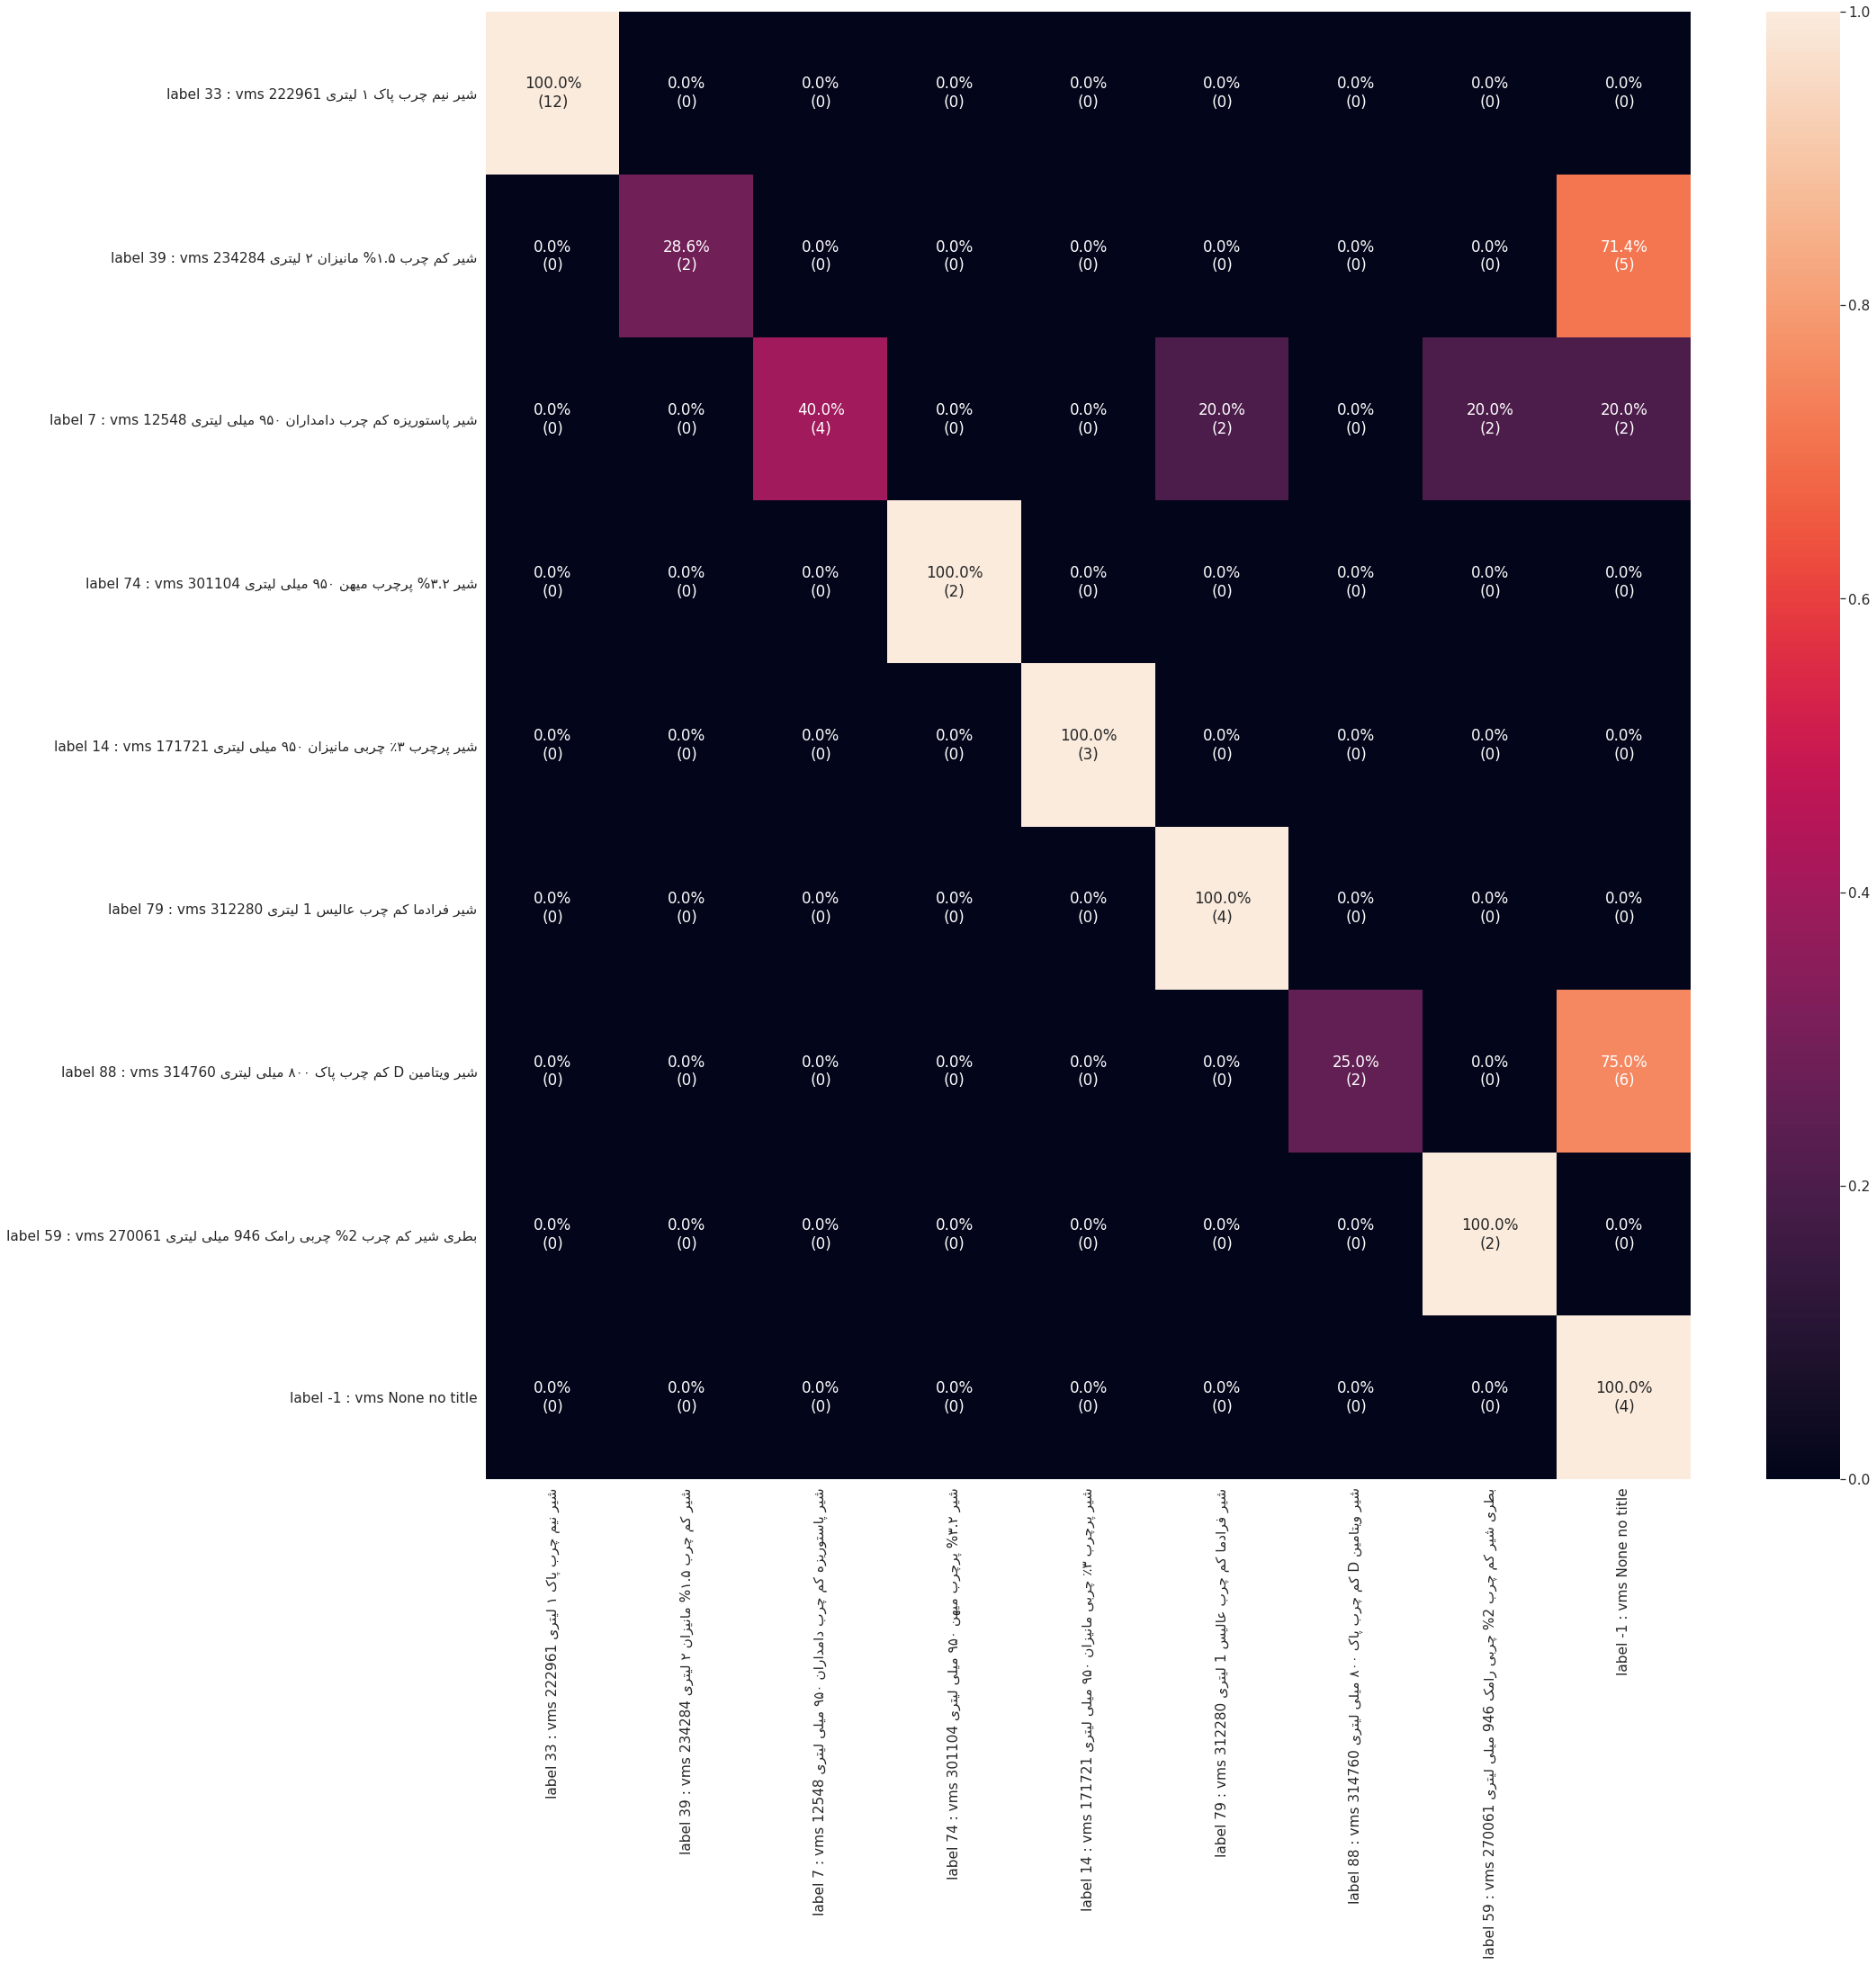

In [219]:
ll=[]
for x in vms_true:
    if x:
        ll.append(dict_milk_vms_title['title'].get(int(x)))
    else:
        ll.append('no title')
ll = [farsiz(x) for x in ll]

zip_vms_code_title = zip(set_Y_true,vms_true,ll )

sns.set(font_scale=1.4)
plt.figure(figsize=(30,30))


cm = confusion_matrix(Y_true, preds, labels=set_Y_true)
b=cm.sum(axis=1).reshape(-1,1)
cm_p = np.divide(cm,
              b,
#               out=np.zeros_like(cm),
              where=b!=0
             )

df1 = pd.DataFrame(cm_p)
df2 = pd.DataFrame(cm)

cm_fr = ((df1*100).round(1).astype(str) + '%\n(' + df2.astype(str) + ')').values

ax_labels = [f'label {x} : vms {y} {z}' for x,y,z in zip_vms_code_title]
fig = sns.heatmap(cm_p,
            annot=cm_fr,
                  fmt="",
            xticklabels = ax_labels,
            yticklabels= ax_labels,
           );
plt.xticks(rotation=90)
# plt.savefig('confusion_matrix.png',  bbox_inches='tight', pad_inches=0)
# fig.savefig('a.jpeg')

# PREDICT

In [220]:
# predictions = probability_model.predict(data_flow['test'])

In [237]:
# list(data_flow['test'])[:2]

In [263]:
predictions=[]
labels=[]
for x,y in islice(data_flow['test'],53):
    p=model.predict(x)
    l=y
    predictions.append(p)
    labels.append(l)

In [264]:
# predictions = model.predict(data_flow['test'])

## FUNCTIONS 

In [265]:
import os
def plot_image(predictions_array, true_label, img):
    true_label = np.argmax(true_label)
    predicted_label = np.argmax(predictions_array)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.squeeze(img)
    img = img.astype(np.uint8)
    plt.imshow(img, cmap=plt.cm.binary)

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} $\\bf{{{:4.0f}}}\\%$ \nVMS:({})".format(
                                calss_mapping_dict[predicted_label],
                                100*np.max(predictions_array),
                                calss_mapping_dict[true_label]),
                                color=color,
#                                 fontweight='bold',
                                fontsize=18.0)

def plot_value_array(predictions_array, true_label, get_n_first):
    true_label = np.argmax(true_label)
    
    args = np.argsort(predictions_array)[-1*get_n_first:][::-1]
    predictions_array_subset = predictions_array[args]
    xaxis_label = [calss_mapping_dict.get(x) for x in args]
#     true_label = true_label[i]
    
    plt.grid(False)
    plt.xticks(range(num_classes))
    plt.xticks(rotation=90)
    plt.yticks([])
    thisplot = plt.bar(xaxis_label,
                       predictions_array_subset,
                       color="#777777")
    
    ax = plt.gca()
    ax.set_yscale('log')
    #     plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array_subset)
    thisplot[predicted_label].set_color('red')
    if true_label in args:
        thisplot[np.argwhere(args==true_label).item()].set_color('blue')
    return predictions_array_subset 


def add_text(ax, text, fontsize, bbox='red_box', rotation=0):
    xlim = ax.get_xlim()
    xrange = xlim[1] - xlim[0]
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]
    
    if bbox == 'red_box':
        bBox = dict(facecolor='red', alpha= 0.5, pad= 20)
    elif bbox == 'blue_arrow':
        bBox = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2 ,alpha =.5)
    ax.text(xrange/3,
            yrange/2,
            text,
            style='italic',
            bbox= bBox,
           fontsize = fontsize,
           rotation = rotation
           )
#     if annotate:
#         ax.annotate('',
#                     xy=(xrange/2,
#                         ylim[0]),
#                     xytext=(xrange/2, (5.8*yrange)/6),
#                 arrowprops=dict(facecolor='black', shrink=0.05 , alpha=0.1))


def plot_with_vms(vms, axes):
    milk_data_dir = '/workspace/product_classifier/data/milk/'
    num = 4
    ncols = 4
    plt.figure(figsize=(10,10))
    path = milk_data_dir + 'train-val'
    for dirs in os.listdir(path):
        if dirs.endswith(str(vms)):
            p = os.path.join(path, dirs)
#             print(p)
            break
    list_images = list(pathlib.Path(p).rglob('*.jpg'))
    
    zip_axes = zip(np.random.choice(list_images, num), axes)
    for i, (image, ax) in enumerate(zip_axes):
        
        rows = math.ceil(4/ncols)
#         plt.subplot(rows,ncols,i+1)
            
#     plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
        image , label = np.array(Image.open(image)), vms
        image = image.astype(np.uint8)
        ax.axis('off')
        ax.imshow(image[...])
#         plt.imshow(image[...],
#     #                cmap=plt.cm.binary
#                   )
        

0


IndexError: index 60 is out of bounds for axis 0 with size 1

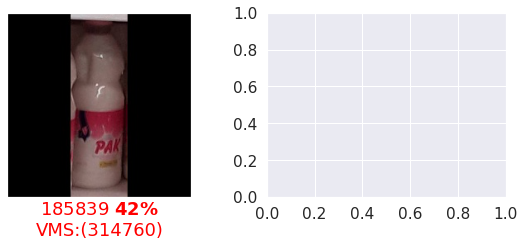

In [267]:
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
fig = plt.figure(figsize=(5*2*num_cols, 4*num_rows))
for i in range(min(num_images, num_samples)):
    print(i)
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(predictions[i],
               labels[i],
               test_images[i])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[i], labels[i], 10)
plt.tight_layout()
plt.show()

# SINGLE IMAGE plot first N guesses

In [81]:
vms = 222961

In [82]:
!ls /workspace/product_classifier/data/milk/test_shelf_crop/$vms/

tmp1i8pnia0.jpg  tmpa4l2tmm4.jpg  tmplwiglqyn.jpg
tmpa3x__i_k.jpg  tmpfcfipzs3.jpg  tmpvcxlmsrn.jpg


In [83]:
image_name = 'tmpvcxlmsrn.jpg'
img_path = f'/workspace/product_classifier/data/milk/test_shelf_crop/{vms}/{image_name}'

In [84]:
# image_name='hph-255690-a.jpg'
# img_path = f'/workspace/product_classifier/data/random/{image_name}'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


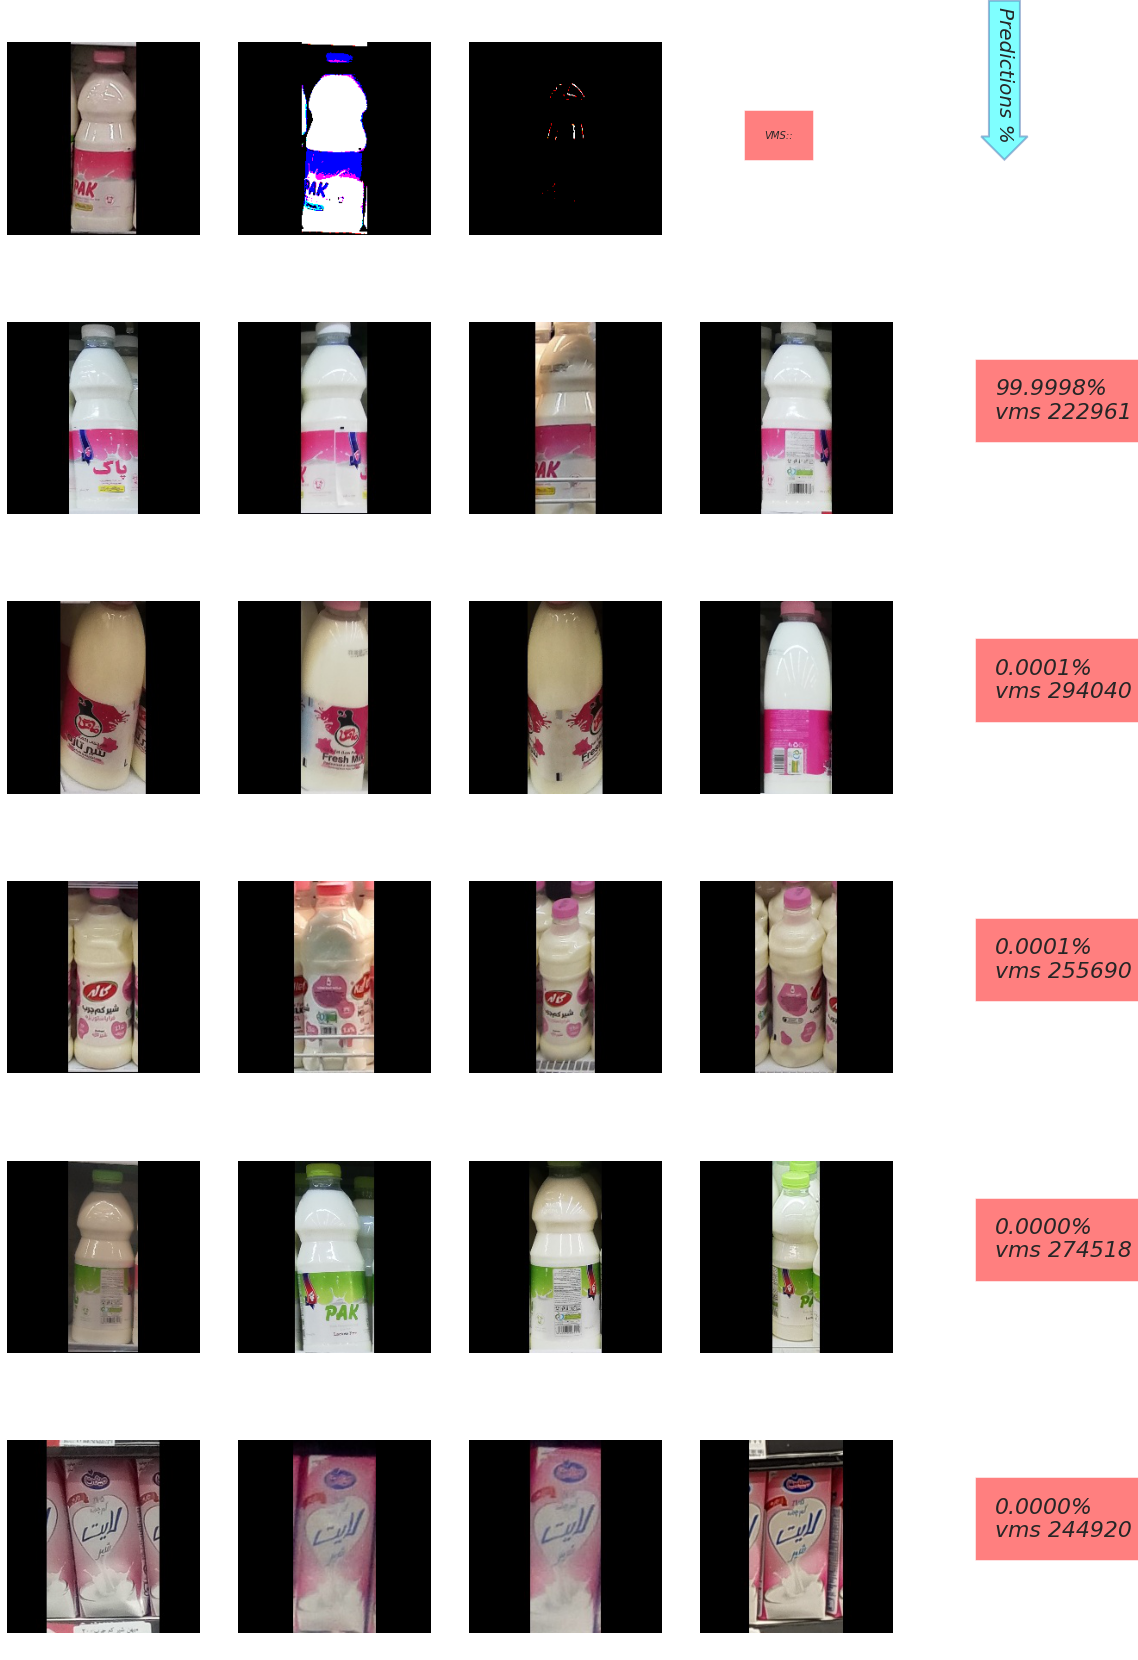

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [85]:
vitro_image_test = image.load_img(img_path,
                                  target_size=(224, 224))

vitro_image_test = image.img_to_array(vitro_image_test)
vitro_image_test = np.expand_dims(vitro_image_test,
                                  axis=0)

imgrgb = vitro_image_test[0,...].astype(np.uint8)

first_n_preds_N = 5
predictions_output = model.predict(vitro_image_test)
predictions_output = np.squeeze(predictions_output)
ss = np.argsort(predictions_output)[::-1][:first_n_preds_N]

first_n_preds = zip(predictions_output[ss],
                    ss,
                    [calss_mapping_dict.get(x) for x in ss])

first_n_preds = list(first_n_preds)


fig, axes = plt.subplots(first_n_preds_N+1, # +1   first row true label
                         5,
                         figsize=(20, 30))

[ax.axis('off') for ax in axes.flatten()]
# row 0 
axes[0,0].imshow(imgrgb)
axes[0,1].imshow(preprocess_input(imgrgb))
axes[0,2].imshow(preprocess_input(preprocess_input(imgrgb)))
add_text(axes[0,3], 'VMS::', 10, rotation=0)
add_text(axes[0,4], 'Predictions %', 20,bbox ='blue_arrow', rotation=-90)

for i , (prob, label , vms) in enumerate(first_n_preds):
    plot_with_vms(vms, axes[i+1,:4])
    add_text(axes[i+1,4], f'{prob:.4%}\nvms {vms}', 22)
    
plt.tight_layout()
plt.show()

## PLOT random 4 image for  a VMS given

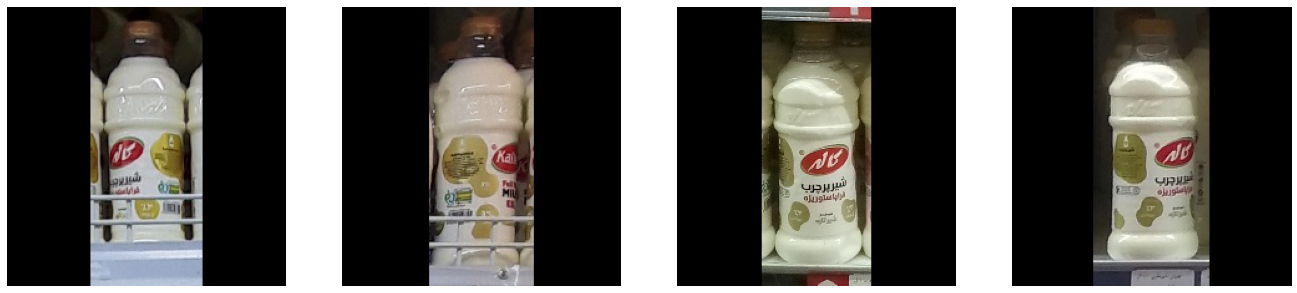

<Figure size 720x720 with 0 Axes>

In [47]:
fig , axes = plt.subplots(1,4,figsize=(23, 15))
plot_with_vms(255691, axes)

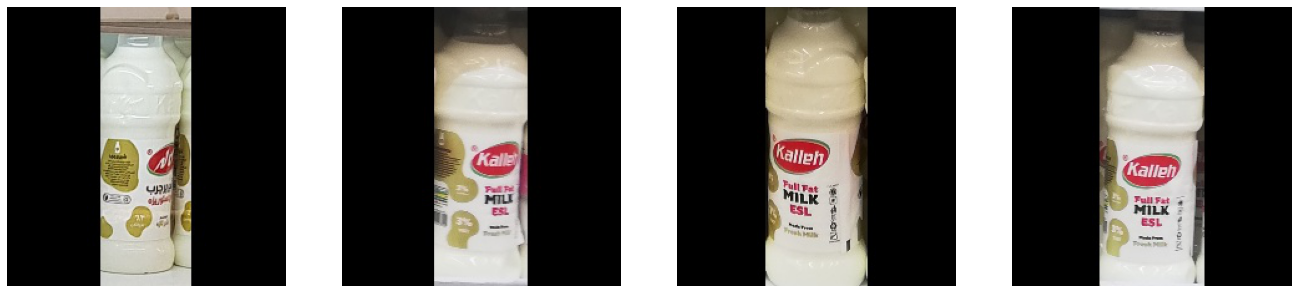

<Figure size 720x720 with 0 Axes>

In [48]:
fig , axes = plt.subplots(1,4,figsize=(23, 15))
plot_with_vms(295693, axes)